In [1]:
from itertools import product
import multiprocessing

import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.sparse as sp
import numpy as np

from fairpair import *

In [2]:
from accuracy_workers import *

## Export Graphs

In [3]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [8]:
sampler = RandomSampling(G, warn=False)
ranker = RankRecovery(G)
path = './data/GNNRank_networks/'

for j in range(101):
    sampler.apply(iter=10, k=1)
    if nx.is_strongly_connected(G): # only apply ranking recovery if strongly connected
        adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
        nodes = np.array(G.nodes)
        sp.save_npz(f'{path}random_iter{j*10}_adj', adj)
        np.save(f'{path}random_iter{j*10}_node_list', nodes)

## Read Results

In [3]:
path = './data/GNNRank_results/'
ranking = np.load(f'{path}DIGRACinnerproduct_pred0.npy')

In [ ]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], data['bias'], data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])

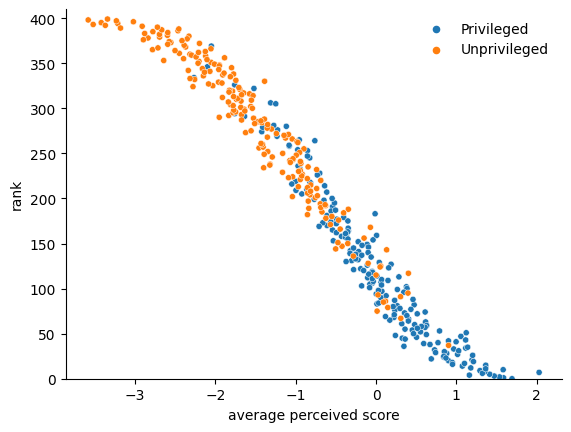

In [14]:
data = ranks
#print(i, list(data['rank']))
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
#data['score'] = data['rank']
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
#plt.setp(ax.collections, alpha=.5)
sns.despine()
#plt.savefig(f'../../Plots/Unified Correlations/corr_perceivedScore_fairPageRank_iteration{i}.png')
#plt.close()
#print(f'saved figure {i}.')